# Instructor Lecture Prep notes (probably not useful for student review)

# Dendrograms and AgglomerativeClustering

1. linkage matrix => dengrogram
2. tree => linkage matrix
3. data => tree

In [1]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from graphviz import Digraph

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["font.size"] = 16

In [4]:
df = pd.DataFrame([[2,1], [5,1], [5,5]], columns=["x", "y"], index=["A", "B", "C"])
df

,x,y
A,2,1
B,5,1
C,5,5


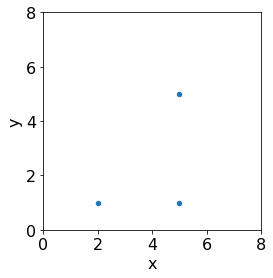

In [5]:
ax = df.plot.scatter(x="x", y="y", xlim=(0,8), ylim=(0,8))
ax.set_aspect("equal")

In [31]:
graph = np.array([
       ["A", None, None, 0, 1],
       ["B", None, None, 0, 1],
       ["C", None, None, 0, 1],
       ["cluster1", 0, 1, 3, 3],
       ["cluster0", 3, 2, 4.5, 2]])
graph = pd.DataFrame(graph, columns=["name", "left", "right", "distance", "nodes"]).fillna("")
graph

,name,left,right,distance,nodes
0,A,,,0.0,1
1,B,,,0.0,1
2,C,,,0.0,1
3,cluster1,0,1,3.0,3
4,cluster0,3,2,4.5,2


{'icoord': [[5.0, 5.0, 15.0, 15.0], [10.0, 10.0, 25.0, 25.0]],
 'dcoord': [[0.0, 3.0, 3.0, 0.0], [3.0, 4.0, 4.0, 0.0]],
 'ivl': ['A', 'B', 'C'],
 'leaves': [0, 1, 2],
 'color_list': ['b', 'b']}

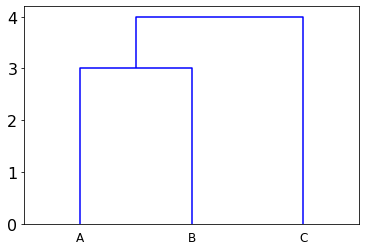

In [30]:
dendrogram(graph.values[3:, 1:].astype(float), labels=graph.values[:3,0])

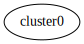

In [32]:
# binary tree for cluster hierarchy:
#  - 0 or 2 children
#  - parent records distance between siblings

class Node:
    def __init__(self, name, left=None, right=None, dist=0, data=None):
        self.name = name
        self.data = data
        self.dist = dist
        self.children = []
        # TODO: fill children, check params

    def draw(self, gv):
        gv.node(self.name)
        for child in self.children:
            child.draw(gv)
            gv.edge(self.name, child.name)

    def __repr__(self):
        return f"Node({self.name})"

    def _repr_svg_(self):
        g = Digraph()
        self.draw(g)
        return g._repr_svg_()

    def fill_node_list(self, nodes, child_count=None):
        pass
        # TODO: fill nodes list with every node in our subtree
        # that has specified child_count (or all if it's None)
    
    def draw_hierarchy(self):
        pass
        # TODO: collect leaf labels and non-leaf linkage matrix.
        # plot dendrogram using these.

A = Node("A", data=df.loc["A"].values)
B = Node("B", data=df.loc["B"].values)
C = Node("C", data=df.loc["C"].values)
Y = Node("cluster1", A, B, 3)
X = Node("cluster0", Y, C, 4)
X

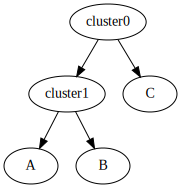

In [14]:
class Node:
    def __init__(self, name, left=None, right=None, dist=0, data=None):
        self.name = name
        self.data = data
        self.dist = dist

        if left != None:
            # non-leaf
            assert right is not None
            assert data == None
            self.children = [left, right]
        else:
            # leaf
            assert dist == 0
            assert data is not None
            self.children = []

    def draw(self, gv):
        gv.node(self.name)
        for child in self.children:
            child.draw(gv)
            gv.edge(self.name, child.name)

    def __repr__(self):
        return f"Node({self.name})"

    def _repr_svg_(self):
        g = Digraph()
        self.draw(g)
        return g._repr_svg_()

    def draw_hierarchy(self):
        leafs = []
        nonleafs = []
        self.fill_node_list(leafs, child_count=0)
        self.fill_node_list(nonleafs, child_count=2)

        names = [node.name for node in leafs]

        for i, n in enumerate(leafs+nonleafs):
            n.idx = i
        linkage = []
        for n in nonleafs:
            linkage.append([n.children[0].idx, n.children[1].idx, n.dist, 0])
        linkage = np.array(linkage).astype(float)
        dendrogram(linkage, labels=names)

    def fill_node_list(self, nodes, child_count=None):
        for c in self.children:
            c.fill_node_list(nodes, child_count=child_count)
        if child_count == None or len(self.children) == child_count:
            nodes.append(self)

    def distance(self, other):
        nodes1 = []
        nodes2 = []
        self.fill_node_list(nodes1, child_count=0)
        other.fill_node_list(nodes2, child_count=0)
        dists = []
        for n1 in nodes1:
            for n2 in nodes2:
                if not n1.data is None and not n2.data is None:
                    dist = ((n1.data - n2.data) ** 2).sum() ** 0.5
                    dists.append(dist)
        return sum(dists) / len(dists)

A = Node("A", data=df.loc["A"].values)
B = Node("B", data=df.loc["B"].values)
C = Node("C", data=df.loc["C"].values)
Y = Node("cluster1", A, B, 3)
X = Node("cluster0", Y, C, 4)
X

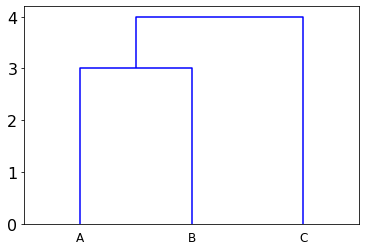

In [15]:
X.draw_hierarchy()

In [16]:
Y.distance(C)

4.5

{Node(B), Node(A), Node(C)}
MERGE Node(B) Node(A) 3.0
{Node(cluster1), Node(C)}
MERGE Node(cluster1) Node(C) 4.5
{Node(cluster0)}


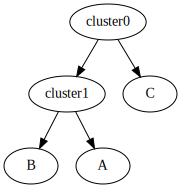

In [17]:
# agglomerative clustering
clusters = {A, B, C}
while len(clusters) > 1:
    print(clusters)
    best_dist = None
    for c1 in clusters:
        for c2 in clusters:
            if c1 is c2:
                continue
            dist = c1.distance(c2)
            if best_dist is None or dist < best_dist:
                best_dist = dist
                best_c1 = c1
                best_c2 = c2
    print("MERGE", best_c1, best_c2, best_dist)
    clusters.remove(best_c1)
    clusters.remove(best_c2)
    new_cluster = Node(f"cluster{len(clusters)}", best_c1, best_c2, best_dist)
    clusters.add(new_cluster)
print(clusters)

root = list(clusters)[0]
root

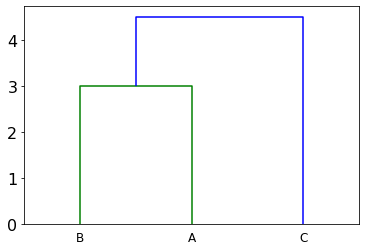

In [18]:
root.draw_hierarchy()

# Practice

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0]],
 'dcoord': [[0.0, 1.0, 1.0, 0.0], [0.0, 2.0, 2.0, 0.0], [1.0, 3.0, 3.0, 2.0]],
 'ivl': ['A', 'B', 'C', 'D'],
 'leaves': [0, 1, 2, 3],
 'color_list': ['g', 'r', 'b']}

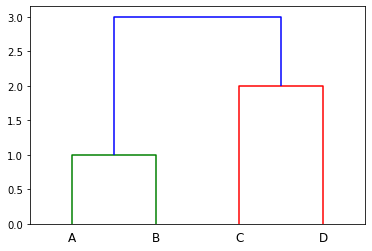

In [2]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import pandas as pd

graph = np.array([
       ["A", None, None, 0, 1],
       ["B", None, None, 0, 1],
       ["C", None, None, 0, 1],
       ["D", None, None, 0, 1],
       ["cluster1", 0, 1, 1, 3],
       ["cluster2", 2, 3, 2, 3],
       ["cluster0", 4, 5, 3, 7]])
graph = pd.DataFrame(graph, columns=["name", "left", "right", "distance", "nodes"]).fillna("")
dendrogram(graph.values[4:, 1:].astype(float), labels=graph.values[:4,0])

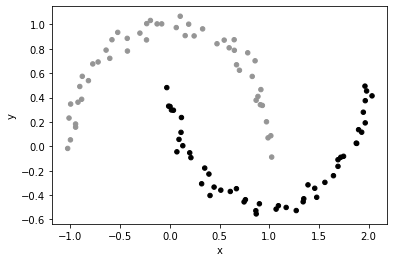

In [30]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_moons
df = pd.DataFrame(make_moons(noise=0.05)[0], columns=["x", "y"])
df["color"] = AgglomerativeClustering(n_clusters=2, linkage="single").fit_predict(df[["x", "y"]])
df.plot.scatter(x="x", y="y", c=df["color"], vmin=-1)

array([[ 1.83808810e+00, -4.55349012e-02],
       [ 7.77479066e-01, -4.74927912e-01],
       [ 8.40400105e-01, -4.87181783e-01],
       [ 1.99179001e+00,  3.72122838e-01],
       [-9.49055747e-01,  3.15108218e-01],
       [ 2.81650650e-01, -1.95682551e-01],
       [ 1.92691676e+00,  1.24732995e-01],
       [ 9.26916757e-01,  3.75267005e-01],
       [ 1.28452759e+00, -4.58667853e-01],
       [-9.91790014e-01,  1.27877162e-01],
       [-7.18349350e-01,  6.95682551e-01],
       [ 6.72300890e-01,  7.40277997e-01],
       [-4.04783343e-01,  9.14412623e-01],
       [ 9.60230259e-02,  9.95379113e-01],
       [ 1.62348980e+00, -2.81831482e-01],
       [ 9.67948422e-01, -4.99486216e-01],
       [ 1.28681296e-01,  9.28244800e-03],
       [ 5.09442530e-02,  1.84891782e-01],
       [ 2.00000000e+00,  5.00000000e-01],
       [-8.38088105e-01,  5.45534901e-01],
       [ 6.23489802e-01,  7.81831482e-01],
       [ 9.90311321e-02,  6.61162609e-02],
       [ 7.61445958e-01,  6.48228395e-01],
       [ 8.